In [5]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import math

from utils import preprocessing as pre
from utils import models_new
import matplotlib.pyplot as plt

In [6]:
# Data loading

dir_ = '/mnt/Archive/Data_Sets/OGT/ogt_classes'

names_class = ['ogt_4_15.fasta', 'ogt_26_37.fasta', 'ogt_48_59.fasta', 'ogt_70_81.fasta']
names_reg = ['ogt_4_15.fasta', 'ogt_15_26.fasta', 'ogt_26_37.fasta', 'ogt_37_48.fasta', 'ogt_48_59.fasta', 'ogt_59_70.fasta', 'ogt_70_81.fasta']


data_train, data_val = pre.prepare_dataset_reg(dir_, names_reg,
                               seq_length = 512,
                               t_v_split = 0.1,
                               max_samples = 3500)

ogt_4_15.fasta 3501
ogt_15_26.fasta 3501
ogt_26_37.fasta 3501
ogt_37_48.fasta 3501
ogt_48_59.fasta 3501
ogt_59_70.fasta 3501
ogt_70_81.fasta 3501


In [4]:
for i, item in enumerate(data_train):
    pass
print(item)

(<tf.Tensor: shape=(512, 21), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=-4.9>)


In [7]:
def coef_det_k(y_true, y_pred):
    """Computer coefficient of determination R^2
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [8]:
# model define

filters = [64, 64, 64, 128, 128, 128, 256, 256, 256]
sizes   = [6, 6, 6, 6, 6, 6, 4, 4, 4]
dilation= [1, 1, 1, 1, 1, 1, 1, 1, 1]
strides = [1, 2, 2, 1, 2, 2, 1, 1, 2]
vocab = 21


opt = keras.optimizers.Adam(learning_rate=0.00001)
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, label_smoothing=0,
    name='categorical_crossentropy'
)
acc = tf.keras.metrics.CategoricalAccuracy(
    name='categorical_accuracy', dtype=None
)


model = models_new.Classifier(filters, sizes, strides, dilation, vocab)

model.compile(optimizer=opt, loss='mse', metrics=[coef_det_k])
model.summary()



Model: "classifier_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 21)]         0         
_________________________________________________________________
tf_op_layer_mul (TensorFlowO [(None, 512, 21)]         0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 512, 21)           0         
_________________________________________________________________
softmax (Softmax)            (None, 512, 21)           0         
_________________________________________________________________
self_attention (SelfAttentio ((None, 512, 21), (None,  169       
_________________________________________________________________
res_mod (ResMod)             (None, 512, 64)           58560     
_________________________________________________________________
res_mod_1 (ResMod)           (None, 256, 64)          

In [5]:
# learning rate schedule
class CustomSchedule(tf.keras.callbacks.Callback):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        self.k1 = (d_model - 1e-7)/warmup_steps
        self.k2 = self.k1/8
        
    def __call__(self, step, lr=0.1):
        step = step*31500/32
        arg1 = self.k1*step + 1e-7
        arg2 = self.d_model - self.k1*step
        arg3 = self.d_model*1/4 -self.k2*step
        return tf.math.minimum(arg1, tf.math.maximum(arg2,arg3))

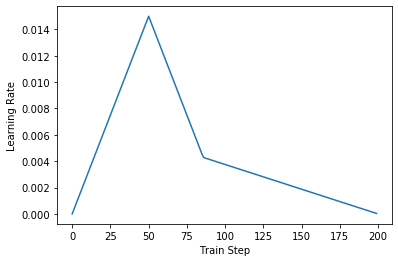

In [21]:
epochs = 200
steps = epochs *  31500/32
lr_schedule = CustomSchedule(0.03, steps/2)
plt.plot(lr_schedule(tf.range(epochs, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [9]:
x_train = data_train.shuffle(buffer_size = 50000).batch(64, drop_remainder=True) 
x_val = data_val.shuffle(buffer_size = 50000).batch(64, drop_remainder=True)

epochs = 50

model.fit(x_train, epochs=epochs, validation_data = x_val)

Epoch 1/50
344/344 [==============================] - 21s 60ms/step - loss: 445.2816 - coef_det_k: 7.8075e-04 - val_loss: 0.0000e+00 - val_coef_det_k: 0.0000e+00
Epoch 2/50
344/344 [==============================] - 16s 45ms/step - loss: 315.4332 - coef_det_k: 0.2904 - val_loss: 322.6310 - val_coef_det_k: 0.2780
Epoch 3/50
344/344 [==============================] - 15s 45ms/step - loss: 293.6352 - coef_det_k: 0.3377 - val_loss: 295.7983 - val_coef_det_k: 0.3444
Epoch 4/50
344/344 [==============================] - 15s 45ms/step - loss: 285.6758 - coef_det_k: 0.3552 - val_loss: 297.8309 - val_coef_det_k: 0.3376
Epoch 5/50
344/344 [==============================] - 15s 45ms/step - loss: 280.2398 - coef_det_k: 0.3675 - val_loss: 305.0033 - val_coef_det_k: 0.3190
Epoch 6/50
344/344 [==============================] - 15s 45ms/step - loss: 274.1713 - coef_det_k: 0.3808 - val_loss: 282.0402 - val_coef_det_k: 0.3716
Epoch 7/50
344/344 [==============================] - 15s 45ms/step - loss: 26

In [11]:
print(opt.lr)

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=1e-04>


In [10]:
model.save_weights('weights/model_ogt')

In [14]:
model.summary()

Model: "classifier_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
res_mod_6 (ResMod)           multiple                  56000     
_________________________________________________________________
res_mod_7 (ResMod)           multiple                  53376     
_________________________________________________________________
res_mod_8 (ResMod)           multiple                  237824    
_________________________________________________________________
res_mod_9 (ResMod)           multiple                  213248    
_________________________________________________________________
res_mod_10 (ResMod)          multiple                  950784    
_________________________________________________________________
res_mod_11 (ResMod)          multiple                  1114624   
_________________________________________________________________
self_attention_1 (SelfAttent multiple                 

In [11]:

x_val = data_val.shuffle(buffer_size = 40000).batch(34, drop_remainder=True)
s = 0
count = 0
for i, x in enumerate(x_val):    
    out = model(x[0], training=True)
    for j in zip(out, x[1].numpy()):
        s += j[0][0].numpy() - j[1]
        count += 1

print(count, s)

2448 3334.3493987321854
